# Semantic and grammatical gender directions in the 14th and 15th legislatures

This notebook explores some statistics on deputies questions during the 14th and 15th French legislatures, specifically in terms of words frequencies. Afterwards, we will focus on identifying the semantic and grammatical gender directions in the questions corpora.


## <a id="content">Contents</a>
1. [Corpora exploration and statistics](#corpora)
2. [Identification of semantic and grammatical gender directions](#semantic-and-grammatical)
   - [Detection of semantic gender direction using PCA](#semantic-pca)
   - [Detection of grammatical gender direction using LDA](#grammatical-lda)
   - [Detection of semantic gender direction using LDA after disentanglement](#semantic-lda-after-disen)
   - [Detection of semantic gender direction using PCA after disentanglement](#semantic-pca-after-disen)

3. [Conclusion](#conclusion)
4. [References](#references)


*Importing useful libraries*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

import mangoes
import gensim

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

import os 
os.chdir("../lib/")
from utils import *
os.chdir("../notebooks/")

## <a id="corpora">1. Corpora exploration and statistics</a> ([&uarr;](#content))

`mangoes` library facilitates computing statistics on text corpora, in particular word frequencies. In our case, this will be specifically useful in order to choose the gender-definition words we will use to compute gender bias metrics.

Therefore, we will define `mangoes` models for questions in leg. XIV and XV. We remind that the questions used are a trimmed version of the originals to remove the heading that look like "Mr/Ms XX asks Mr/Ms YY about". Such statements can in fact bias the gender bias measurement results.

In [2]:
# load questions csv files
df_XIV = pd.read_csv("../data/legislature_XIV/df_questions.csv")
df_XV = pd.read_csv("../data/legislature_XV/df_questions.csv")

# extract list of questions 
corpus_XIV = list(df_XIV['q_text'])
corpus_XV = list(df_XV['q_text'])

In [ ]:
# create mangoes models 
mangoes_XIV = mangoes.Corpus(corpus_XIV)
mangoes_XV = mangoes.Corpus(corpus_XV)

Counting words: 0it [00:00, ?it/s]

Counting words: 0it [00:00, ?it/s]

*Print number of sentences, number of words, and frequencies of some words*

In [ ]:
# number of sentences 
print("CORPUS XIV\n----------")
print(mangoes_XIV.size, "sentences")

# number of words
print(len(mangoes_XIV.words_count), "words")

# frequencies of words
print(mangoes_XIV.words_count["homme"])

print("\nCORPUS XV\n---------")
print(mangoes_XV.size, "sentences")

# number of words
print(len(mangoes_XV.words_count), "words")

# frequencies of words
print(mangoes_XV.words_count["homme"])

CORPUS XIV
----------
19734602 sentences
88885 words
1651

CORPUS XV
---------
12702160 sentences
86135 words
1222


Now, let us define a potential list of gender-definition words and compute their frequencies in the corpora.

In [ ]:
# gender-definition pairs
gender_def = [["femme", "homme"], ["femmes", "hommes"], ['mme', 'mr'],
              ["fille", "fils"], ["mère", "père"], ["mères", "pères"],["femelle", "mâle"], 
              ["sœur", "frère"], ["madame", "monsieur"], ["tante", "oncle"]]

# counts of gender words 
l_count_XIV = np.empty(shape=(len(gender_def), 2))  # leg. XIV
l_count_XV = np.empty(shape=(len(gender_def), 2))   # leg. XV

# percentage of each gender-definition word in the corresponding gender pair
l_perc_XIV = np.empty(shape=(len(gender_def), 2))   # leg. XIV
l_perc_XV = np.empty(shape=(len(gender_def), 2))    # leg. XV

# compute the counts and percentages 
for i, [female, male] in enumerate(gender_def):
  fem_XIV, mal_XIV = mangoes_XIV.words_count[female], mangoes_XIV.words_count[male]
  l_count_XIV[i] = fem_XIV, mal_XIV
  l_perc_XIV[i] = fem_XIV/(fem_XIV+mal_XIV), mal_XIV/(fem_XIV+mal_XIV)

  fem_XV, mal_XV = mangoes_XV.words_count[female], mangoes_XV.words_count[male]
  l_count_XV[i] = fem_XV, mal_XV
  l_perc_XV[i] = fem_XV/(fem_XV+mal_XV), mal_XV/(fem_XV+mal_XV)


# create dataframes with gender-word, counts and percentages 
df_dict_XIV = {'tuple':np.array([[i,i] for i in range(len(gender_def))]).ravel(),
           'name' : np.array(gender_def).ravel(),
           'count' : l_count_XIV.ravel(),
           'percentage' : l_perc_XIV.ravel(),
           'gender': np.array([['F', 'M'] for i in range(len(gender_def))]).ravel()
}
df_dict_XV = {'tuple':np.array([[i,i] for i in range(len(gender_def))]).ravel(),
           'name' : np.array(gender_def).ravel(),
           'count' : l_count_XV.ravel(),
           'percentage' : l_perc_XV.ravel(),
           'gender': np.array([['F', 'M'] for i in range(len(gender_def))]).ravel()
}
df_XIV = pd.DataFrame(df_dict_XIV)
df_XV = pd.DataFrame(df_dict_XV)

In [ ]:
df_XIV.head(4)

,tuple,name,count,percentage,gender
0,0,femme,547.0,0.248863,F
1,0,homme,1651.0,0.751137,M
2,1,femmes,9906.0,0.885888,F
3,1,hommes,1276.0,0.114112,M


*Plots of gender-definition word counts*

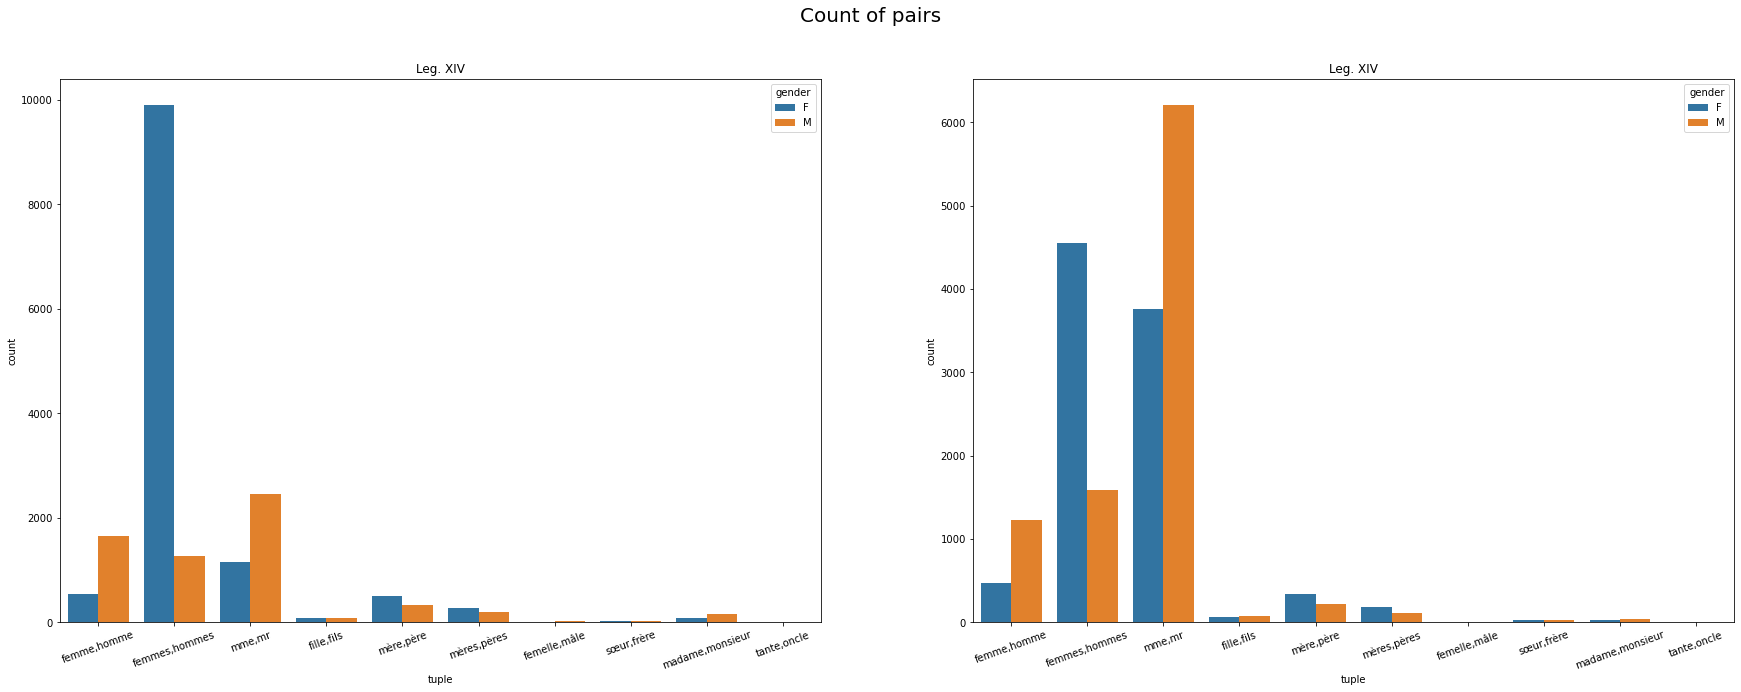

In [ ]:
# plot of gender words counts in leg. XIV
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
g_XIV = sns.barplot(data=df_XIV, y='count', x="tuple", hue="gender", ax=axes[0])
g_XIV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[0].set_title('Leg. XIV')

# plot of gender words counts in leg. XV
g_XV = sns.barplot(data=df_XV, y='count', x="tuple", hue="gender", ax=axes[1])
g_XV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[1].set_title('Leg. XV')
plt.suptitle('Count of pairs', fontsize=20)
plt.show()

It might be more relevant to actually look at the percentage of each word in its corresponding pair. For instance, for the pair `[femme, homme]`, we would be interested in seing how many times `femme` is more used than `homme`.

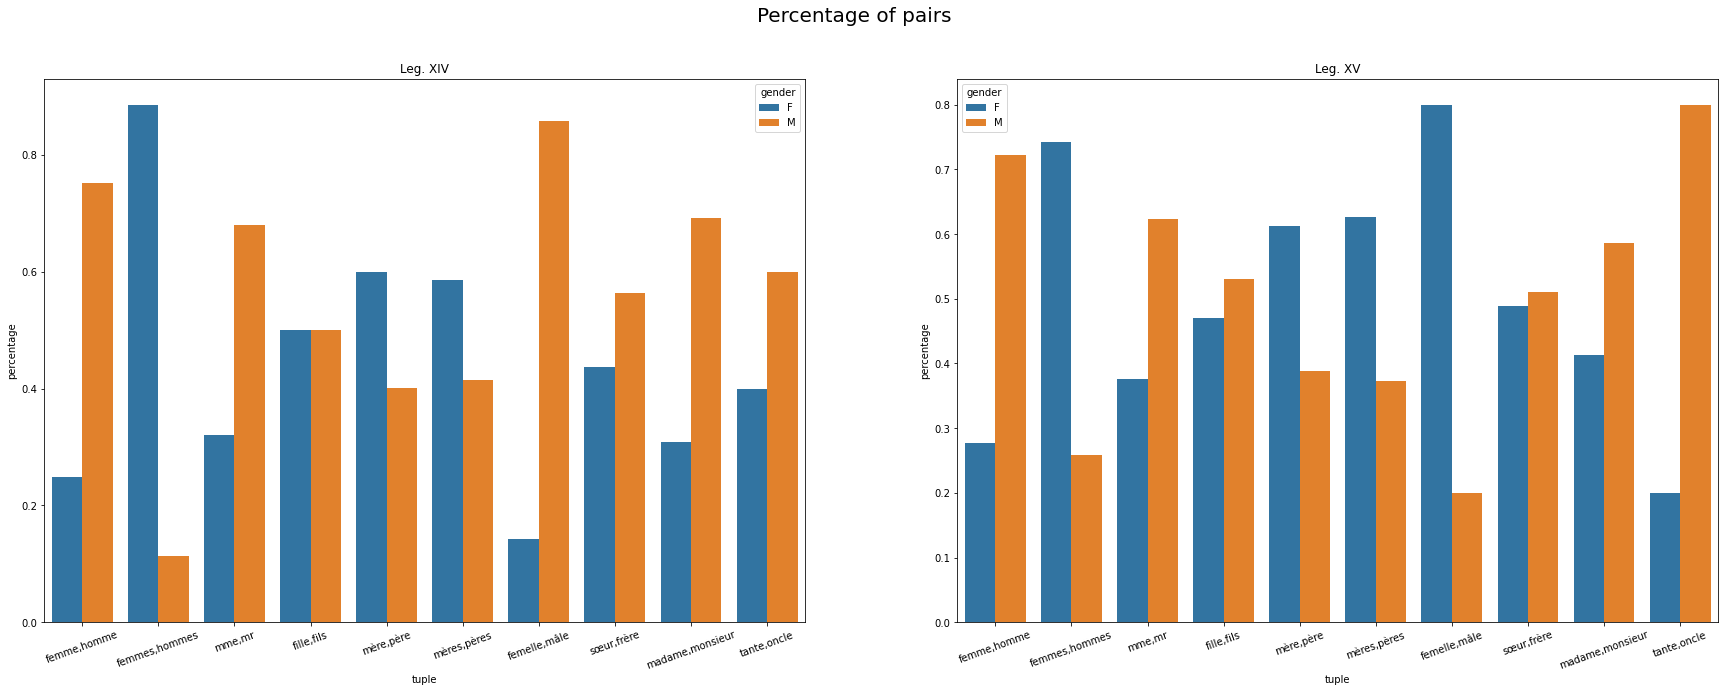

In [ ]:
# plot of gender words percentages in leg. XIV
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
g_XIV = sns.barplot(data=df_XIV, y='percentage', x="tuple", hue="gender", ax=axes[0])
g_XIV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[0].set_title('Leg. XIV')

# plot of gender words percentages in leg. XV
g_XV = sns.barplot(data=df_XV, y='percentage', x="tuple", hue="gender", ax=axes[1])
g_XV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[1].set_title('Leg. XV')
plt.suptitle('Percentage of pairs', fontsize=20)
plt.show()


It is important to consider only the pairs for which the percentage of women:men is $\approx$ 50:50. However, since there is not many of such gender pairs, we can tolerate some margin of difference in the percentages.

As a matter of fact, there is another decisive factor on the choice of the gender-defintion words: how there pairs encode the gender semantics. This will be decided later in the sections dedicated to identofying the semantic gender direction. 

In the sequel, we can consider the following pairs: 
>* femme/homme and femmes/hommes (although the difference of percentages are high, we hope that the 2 pairs will cancel this together)
>* mme/mr
>* fille/fils
>* mère/père and mères/pères
>* soeur/frère
>* madame/monsieur



## <a id="semantic-and-grammatical">2. Identification of semantic and grammatical gender directions</a> ([&uarr;](#content))

*We load Skip-Gram and CBOW word2vec models that are trained on (trimmed) questions of leg. XIV and leg. XV.*

In [2]:
# load models of the 14th legislature 
cbow_XIV_200 = gensim.models.Word2Vec.load('../../cbow_XIV/w2v_cbow_200D_fth_cleaned').wv
cbow_XIV_500 = gensim.models.Word2Vec.load('../../cbow_XIV/w2v_cbow_500D_fth_cleaned').wv
sg_XIV_200 = gensim.models.Word2Vec.load('../../sg_XIV/w2v_sg_200D_fth_cleaned').wv
sg_XIV_500 = gensim.models.Word2Vec.load('../../sg_XIV/w2v_sg_500D_fth_cleaned').wv

# load models of the 15th legislature 
cbow_XV_200 = gensim.models.Word2Vec.load('../../cbow_XV/w2v_cbow_200D_fth_cleaned').wv
cbow_XV_500 = gensim.models.Word2Vec.load('../../cbow_XV/w2v_cbow_500D_fth_cleaned').wv
sg_XV_200 = gensim.models.Word2Vec.load('../../sg_XV/w2v_sg_200D_fth_cleaned').wv
sg_XV_500 = gensim.models.Word2Vec.load('../../sg_XV/w2v_sg_500D_fth_cleaned').wv

Print most similar words to a specific `word` in each pre-trained model.

In [3]:
word = 'ministre'
print('Model CBOW XIV 200')
print(cbow_XIV_200.most_similar(word, topn=5))
print('Model CBOW XIV 500')
print(cbow_XIV_500.most_similar(word, topn=5))
print('Model SG XIV 200')
print(sg_XIV_200.most_similar(word, topn=5))
print('Model SG XIV 500')
print(sg_XIV_500.most_similar(word, topn=5))

print('\nModel CBOW XV 200')
print(cbow_XV_200.most_similar(word, topn=5))
print('Model CBOW XV 500')
print(cbow_XV_500.most_similar(word, topn=5))
print('Model SG XV 200')
print(sg_XV_200.most_similar(word, topn=5))
print('Model SG XV 500')
print(sg_XV_500.most_similar(word, topn=5))


Model CBOW XIV 200
[('secrétaire', 0.5057457685470581), ('ministère', 0.49380213022232056), ('gouvernement', 0.39455801248550415), ('françoise', 0.39321455359458923), ('rapporteur', 0.38865506649017334)]
Model CBOW XIV 500
[('secrétaire', 0.45403018593788147), ('ministère', 0.4311947524547577), ('gouvernement', 0.3550567328929901), ('laurence', 0.3267216682434082), ('députée', 0.32546794414520264)]
Model SG XIV 200
[('délégué', 0.5452001690864563), ('secrétaire', 0.46953725814819336), ('chargé', 0.46341457962989807), ('déléguée', 0.4398200809955597), ('auprès', 0.4292590320110321)]
Model SG XIV 500
[('délégué', 0.4526582658290863), ('chargé', 0.41214287281036377), ('ministère', 0.3596785366535187), ('secrétaire', 0.3594585359096527), ('déléguée', 0.35873109102249146)]

Model CBOW XV 200
[('minsitre', 0.6022796630859375), ('secrétaire', 0.5729760527610779), ('député', 0.5315444469451904), ('daemi', 0.51891028881073), ('ministère', 0.509676456451416)]
Model CBOW XV 500
[('minsitre', 0.55

### <a id="semantic-pca">2.1. Detection of semantic gender direction using PCA</a> ([&uarr;](#content))

To identify the semantic gender direction, we compute the difference between the gender forms constituting each gender-defintion pair. The semantic gender direction is therefore identified as the principal component of these difference. We use PCA for that purpose.

This method for exhibiting the semantic gender direction is used by many papers, for example [Zhou et al.](https://aclanthology.org/D19-1531.pdf).

In [4]:
# gender-definition word pairs
female_def_words = "soeur mère fille féminin mme".split()
male_def_words = "frère père garçon masculin mr".split()

# semantic direction using PCA
comp_cbow_XIV_200, sing_val_cbow_XIV_200 = semantic_dirct_PCA(cbow_XIV_200, female_def_words, male_def_words, get_sing_values=True)
comp_cbow_XIV_500, sing_val_cbow_XIV_500 = semantic_dirct_PCA(cbow_XIV_500, female_def_words, male_def_words, get_sing_values=True)
comp_sg_XIV_200, sing_val_sg_XIV_200 = semantic_dirct_PCA(sg_XIV_200, female_def_words, male_def_words, get_sing_values=True)
comp_sg_XIV_500, sing_val_sg_XIV_500 = semantic_dirct_PCA(sg_XIV_500, female_def_words, male_def_words, get_sing_values=True)

comp_cbow_XV_200, sing_val_cbow_XV_200 = semantic_dirct_PCA(cbow_XV_200, female_def_words, male_def_words, get_sing_values=True)
comp_cbow_XV_500, sing_val_cbow_XV_500 = semantic_dirct_PCA(cbow_XV_500, female_def_words, male_def_words, get_sing_values=True)
comp_sg_XV_200, sing_val_sg_XV_200 = semantic_dirct_PCA(sg_XV_200, female_def_words, male_def_words, get_sing_values=True)
comp_sg_XV_500, sing_val_sg_XV_500 = semantic_dirct_PCA(sg_XV_500, female_def_words, male_def_words, get_sing_values=True)

Plot of the gender-space associated singular values of each word2vec model

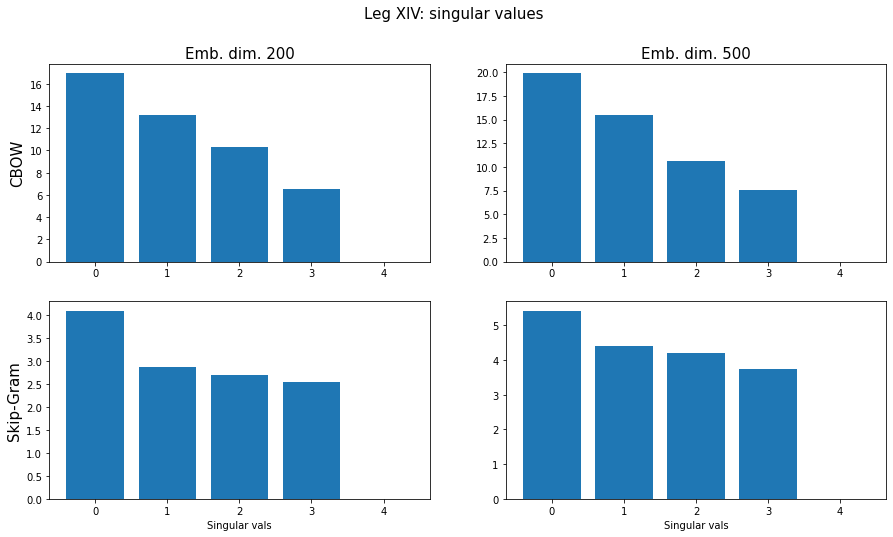

In [5]:
# plot the gender-space singular values of each word2vec model
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
font_size=15

axes[0, 0].bar(x=np.arange(len(sing_val_cbow_XIV_200)), height=sing_val_cbow_XIV_200)
axes[0, 1].bar(x=np.arange(len(sing_val_cbow_XIV_500)), height=sing_val_cbow_XIV_500)
axes[1, 0].bar(x=np.arange(len(sing_val_sg_XIV_200)), height=sing_val_sg_XIV_200)
axes[1, 1].bar(x=np.arange(len(sing_val_sg_XIV_500)), height=sing_val_sg_XIV_500)

# axis labeling
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel("Singular vals",)
axes[1, 1].set_xlabel("Singular vals",)

# set plot titles
axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
plt.suptitle('Leg XIV: singular values',fontsize=font_size)

plt.show()

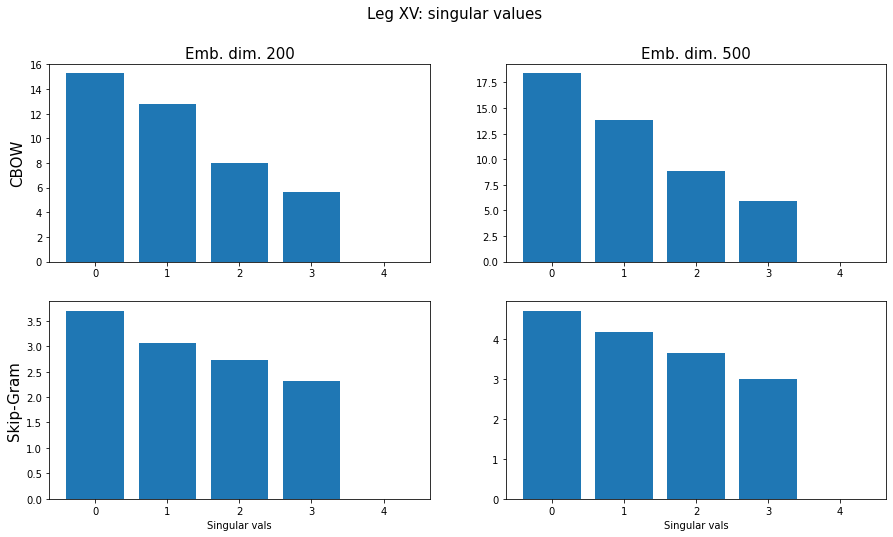

In [43]:
# plot the gender-space singular values of each word2vec model
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
font_size=15

axes[0, 0].bar(x=np.arange(len(sing_val_cbow_XV_200)), height=sing_val_cbow_XV_200)
axes[0, 1].bar(x=np.arange(len(sing_val_cbow_XV_500)), height=sing_val_cbow_XV_500)
axes[1, 0].bar(x=np.arange(len(sing_val_sg_XV_200)), height=sing_val_sg_XV_200)
axes[1, 1].bar(x=np.arange(len(sing_val_sg_XV_500)), height=sing_val_sg_XV_500)

# axis labeling
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel("Singular vals",)
axes[1, 1].set_xlabel("Singular vals",)

# set plot titles
axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
plt.suptitle('Leg XV: singular values',fontsize=font_size)

plt.show()

**Comment:** The singular values are generally close to each other. This will therefore make the use of the 1st priincipal component less efficient in exhibiting the gender semantics.

*We will project the word embeddings onto the gender space composed of the 1st principal gender component (obtained by PCA applied of the differences of gender pairs embeddings).*

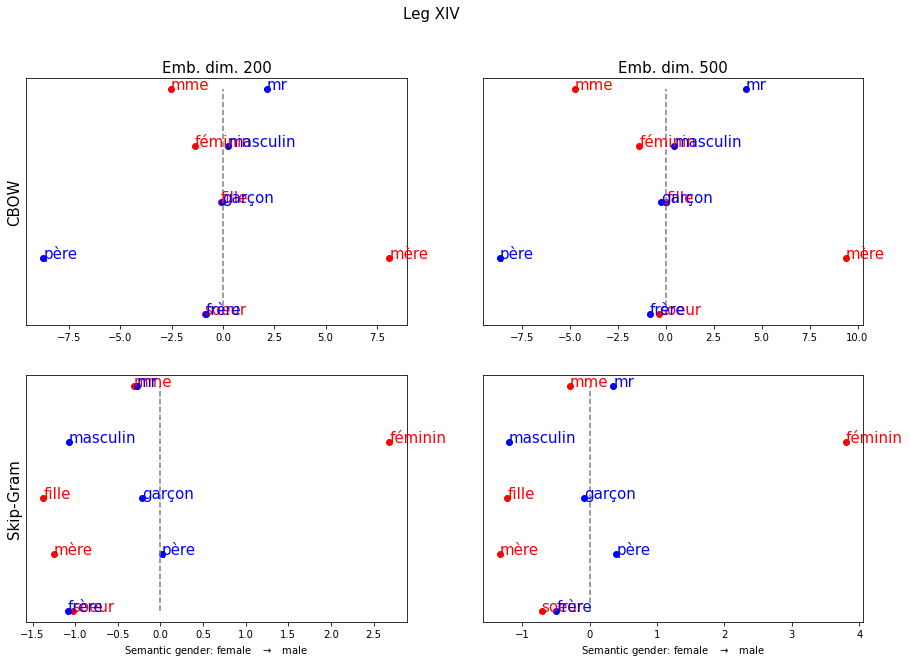

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
font_size=15

# female and male gender definition word embeddings
female_embed_cbow_XIV_200, male_embed_cbow_XIV_200 = cbow_XIV_200[female_def_words], cbow_XIV_200[male_def_words]
female_embed_cbow_XIV_500, male_embed_cbow_XIV_500 = cbow_XIV_500[female_def_words], cbow_XIV_500[male_def_words]
female_embed_sg_XIV_200, male_embed_sg_XIV_200 = sg_XIV_200[female_def_words], sg_XIV_200[male_def_words]
female_embed_sg_XIV_500, male_embed_sg_XIV_500 = sg_XIV_500[female_def_words], sg_XIV_500[male_def_words]
#female_embed_cbow_XV, male_embed_cbow_XV = cbow_XV.wv[female_def_words], cbow_XV.wv[male_def_words]
#female_embed_sg_XV, male_embed_sg_XV = sg_XV.wv[female_def_words], sg_XV.wv[male_def_words]

# projection onto the gender space (1st principal component)
female_proj_cbow_XIV_200, male_proj_cbow_XIV_200 = proj_onto_space(female_embed_cbow_XIV_200, comp_cbow_XIV_200[0]), proj_onto_space(male_embed_cbow_XIV_200, comp_cbow_XIV_200[0])
female_proj_cbow_XIV_500, male_proj_cbow_XIV_500 = proj_onto_space(female_embed_cbow_XIV_500, comp_cbow_XIV_500[0]), proj_onto_space(male_embed_cbow_XIV_500, comp_cbow_XIV_500[0])
female_proj_sg_XIV_200, male_proj_sg_XIV_200 = proj_onto_space(female_embed_sg_XIV_200, comp_sg_XIV_200[0]), proj_onto_space(male_embed_sg_XIV_200, comp_sg_XIV_200[0])
female_proj_sg_XIV_500, male_proj_sg_XIV_500 = proj_onto_space(female_embed_sg_XIV_500, comp_sg_XIV_500[0]), proj_onto_space(male_embed_sg_XIV_500, comp_sg_XIV_500[0])

# plot projections 
scatter_align_words(female_proj_cbow_XIV_200.reshape(-1), male_proj_cbow_XIV_200.reshape(-1), female_def_words, male_def_words, ax=axes[0, 0])
scatter_align_words(female_proj_cbow_XIV_500.reshape(-1), male_proj_cbow_XIV_500.reshape(-1),female_def_words, male_def_words, ax=axes[0, 1])
scatter_align_words(female_proj_sg_XIV_200.reshape(-1), male_proj_sg_XIV_200.reshape(-1), female_def_words, male_def_words, ax=axes[1, 0])
scatter_align_words(female_proj_sg_XIV_500.reshape(-1), male_proj_sg_XIV_500.reshape(-1), female_def_words, male_def_words, ax=axes[1, 1])

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

# remove yticks 
axes[0, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)

plt.suptitle('Leg XIV',fontsize=font_size)

plt.show()

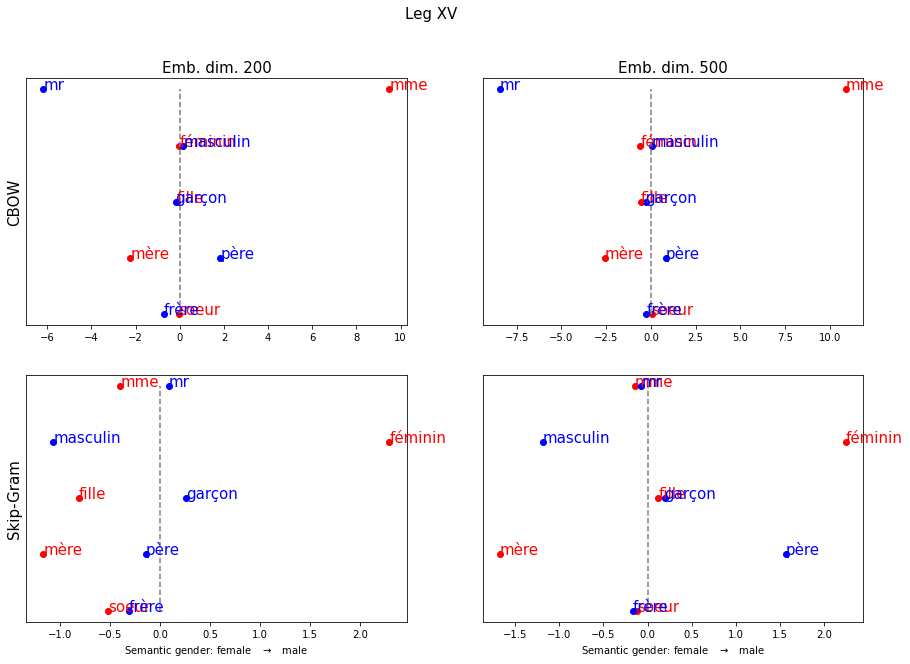

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
font_size=15

# female and male gender definition word embeddings
female_embed_cbow_XV_200, male_embed_cbow_XV_200 = cbow_XV_200[female_def_words], cbow_XV_200[male_def_words]
female_embed_cbow_XV_500, male_embed_cbow_XV_500 = cbow_XV_500[female_def_words], cbow_XV_500[male_def_words]
female_embed_sg_XV_200, male_embed_sg_XV_200 = sg_XV_200[female_def_words], sg_XV_200[male_def_words]
female_embed_sg_XV_500, male_embed_sg_XV_500 = sg_XV_500[female_def_words], sg_XV_500[male_def_words]
#female_embed_cbow_XV, male_embed_cbow_XV = cbow_XV.wv[female_def_words], cbow_XV.wv[male_def_words]
#female_embed_sg_XV, male_embed_sg_XV = sg_XV.wv[female_def_words], sg_XV.wv[male_def_words]

# projection onto the gender space (1st principal component)
female_proj_cbow_XV_200, male_proj_cbow_XV_200 = proj_onto_space(female_embed_cbow_XV_200, comp_cbow_XV_200[0]), proj_onto_space(male_embed_cbow_XV_200, comp_cbow_XV_200[0])
female_proj_cbow_XV_500, male_proj_cbow_XV_500 = proj_onto_space(female_embed_cbow_XV_500, comp_cbow_XV_500[0]), proj_onto_space(male_embed_cbow_XV_500, comp_cbow_XV_500[0])
female_proj_sg_XV_200, male_proj_sg_XV_200 = proj_onto_space(female_embed_sg_XV_200, comp_sg_XV_200[0]), proj_onto_space(male_embed_sg_XV_200, comp_sg_XV_200[0])
female_proj_sg_XV_500, male_proj_sg_XV_500 = proj_onto_space(female_embed_sg_XV_500, comp_sg_XV_500[0]), proj_onto_space(male_embed_sg_XV_500, comp_sg_XV_500[0])

# plot projections 
scatter_align_words(female_proj_cbow_XV_200.reshape(-1), male_proj_cbow_XV_200.reshape(-1), female_def_words, male_def_words, ax=axes[0, 0])
scatter_align_words(female_proj_cbow_XV_500.reshape(-1), male_proj_cbow_XV_500.reshape(-1),female_def_words, male_def_words, ax=axes[0, 1])
scatter_align_words(female_proj_sg_XV_200.reshape(-1), male_proj_sg_XV_200.reshape(-1), female_def_words, male_def_words, ax=axes[1, 0])
scatter_align_words(female_proj_sg_XV_500.reshape(-1), male_proj_sg_XV_500.reshape(-1), female_def_words, male_def_words, ax=axes[1, 1])

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

# remove yticks 
axes[0, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)

plt.suptitle('Leg XV',fontsize=font_size)

plt.show()

**Comment:**

As noticed from the results, PCA is not efficient to extract the semantic gender direction in the case of our corpus. We will attempt with LDA instead.

However, it is important to first extract the grammatical gender direction and remove out the grammatical component from the embeddings of gender-definition words that will be used with LDA. Otherwise, it is not excluded that the LDA-identified direction is simply the grammatical gender direction.

### <a id="grammatical-lda">2.2. Detecting the grammatical gender direction using LDA</a> ([&uarr;](#content))
The identification of the grammatical gender direction goes through classiyfing words according to their grammatical gender using Linear Discriminant Analysis (LDA). The normal vector to the separating hyperplane is the direction of the grammatical gender. 

To disentangle the grammatical gender components, we use the iterative approach suggested by [Sabbaghi et al.](https://arxiv.org/pdf/2206.01691.pdf), as it is more efficient than the one step disentanglement (see test score plots below).

*Loading lists of grammatical gender words*

In [3]:
# loading grammatical gender word lists
with open("../data/grammatical_masculine.txt", "r") as output:
    masc_gram = output.read()
    output.close()

with open("../data/grammatical_feminine.txt", "r") as output:
    fem_gram = output.read()
    output.close()

# grammatically feminine and masculine words
fem_gram = fem_gram.split('\n')
masc_gram = masc_gram.split('\n')
fem_gram[:4], masc_gram[:4]

(['rhétorique', 'vente', 'suite', 'certification'],
 ['orient', 'hôtel', 'mâle', 'penta-logarithme'])

*Some words might not have existed in the original corpora. It is thereofre important to detect them and construct a final list of grammatically gendered words that will be used for LDA.*

In [4]:
# final lists of grammatically gendered words
final_gram_fem, final_gram_masc = [], []
for word in fem_gram:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        final_gram_fem.append(word)

for word in masc_gram:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        final_gram_masc.append(word)
print(len(final_gram_fem), len(final_gram_masc))


# keep the same size for both lists
n_words = min(len(final_gram_fem), len(final_gram_masc))
final_gram_fem, final_gram_masc = final_gram_fem[:n_words], final_gram_masc[:n_words]
print(len(final_gram_fem), len(final_gram_masc))

896 963
896 896


*Get the principal grammatical gender direction using LDA*

We recall that the grammatical gender components are extracted iteratively and stored in numpy arrays (e.g. `gram_dir_cbow_XIV_200`). These will later be used to grammatically disentangle word embeddings.

In [5]:
# iterative extraction of the grammatical gender direction 
# leg XIV
test_score_cbow_XIV_200, gram_dir_cbow_XIV_200 = gram_dirct(cbow_XIV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_cbow_XIV_500, gram_dir_cbow_XIV_500 = gram_dirct(cbow_XIV_500, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XIV_200, gram_dir_sg_XIV_200 = gram_dirct(sg_XIV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XIV_500, gram_dir_sg_XIV_500 = gram_dirct(sg_XIV_500, final_gram_masc, final_gram_fem, test_size=.2)

# leg XV
test_score_cbow_XV_200, gram_dir_cbow_XV_200 = gram_dirct(cbow_XV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_cbow_XV_500, gram_dir_cbow_XV_500 = gram_dirct(cbow_XV_500, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XV_200, gram_dir_sg_XV_200 = gram_dirct(sg_XV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XV_500, gram_dir_sg_XV_500 = gram_dirct(sg_XV_500, final_gram_masc, final_gram_fem, test_size=.2)


*Plot of the classification test scores after each disentanglement step*

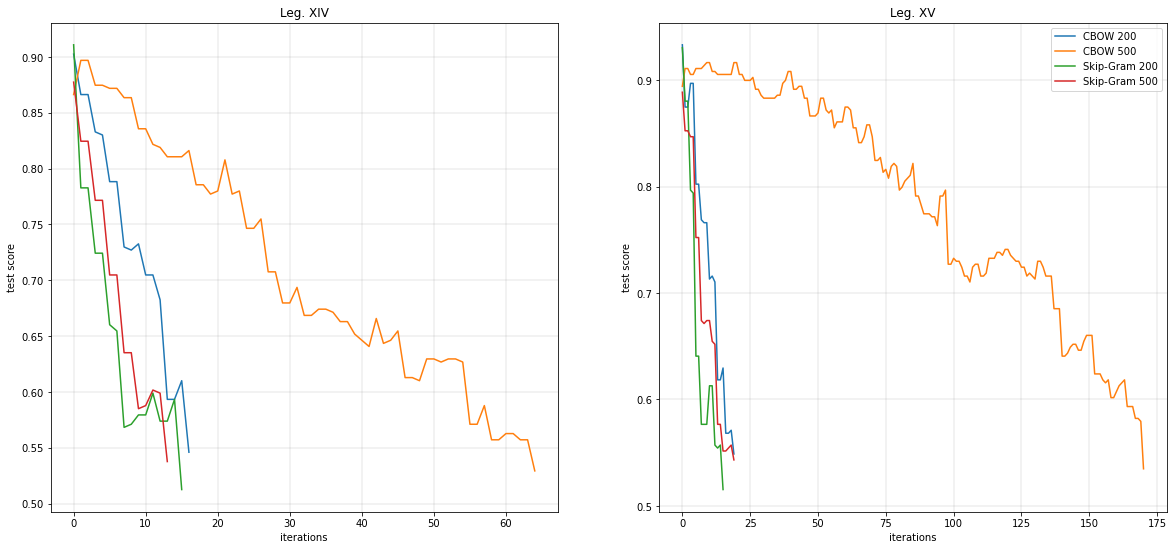

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

axes[0].plot(test_score_cbow_XIV_200, label='CBOW 200')
axes[0].plot(test_score_cbow_XIV_500, label='CBOW 500')
axes[0].plot(test_score_sg_XIV_200, label='Skip-Gram 200')
axes[0].plot(test_score_sg_XIV_500, label='Skip-Gram 500')
axes[0].set_title('Leg. XIV')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('test score')
axes[0].grid(color='gray', linestyle='-', linewidth=.2)

axes[1].plot(test_score_cbow_XV_200, label='CBOW 200')
axes[1].plot(test_score_cbow_XV_500, label='CBOW 500')
axes[1].plot(test_score_sg_XV_200, label='Skip-Gram 200')
axes[1].plot(test_score_sg_XV_500, label='Skip-Gram 500')
axes[1].set_title('Leg. XV')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('test score')

axes[1].grid(color='gray', linestyle='-', linewidth=.2)

plt.legend()
plt.show()

**Comment:** We clearly see how inefficient it is to content ourselves with a single disentanglement step. In fact, the classification scores are still quite high after one grammatical disentanglement step.

To illustrate this even more clearly, we project the word embeddings after the first disentanglement step on the second identified grammatical gender direction to see if it still possible to sperate the words according to their grammatical gender. We do the same after the before-last step of disentanglement and compare the results.

In [7]:
# for better visualisation, we restrict ourselves to 10 words
n_words = 10

# one disentanglement iteration
disen_1_fem_cbow_XIV_200, disen_1_masc_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, final_gram_fem[:n_words], gram_dir_cbow_XIV_200[0:1]), disentangle_gram_dirct(cbow_XIV_200, final_gram_masc[:n_words], gram_dir_cbow_XIV_200[0:1])
disen_1_fem_cbow_XIV_500, disen_1_masc_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, final_gram_fem[:n_words], gram_dir_cbow_XIV_500[0:1]), disentangle_gram_dirct(cbow_XIV_500, final_gram_masc[:n_words], gram_dir_cbow_XIV_500[0:1])
disen_1_fem_sg_XIV_200, disen_1_masc_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, final_gram_fem[:n_words], gram_dir_sg_XIV_200[0:1]), disentangle_gram_dirct(sg_XIV_200, final_gram_masc[:n_words], gram_dir_sg_XIV_200[0:1])
disen_1_fem_sg_XIV_500, disen_1_masc_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, final_gram_fem[:n_words], gram_dir_sg_XIV_500[0:1]), disentangle_gram_dirct(sg_XIV_500, final_gram_masc[:n_words], gram_dir_sg_XIV_500[0:1])

proj_1_fem_cbow_XIV_200, proj_1_masc_cbow_XIV_200 = proj_onto_space(disen_1_fem_cbow_XIV_200, gram_dir_cbow_XIV_200[1]), proj_onto_space(disen_1_masc_cbow_XIV_200, gram_dir_cbow_XIV_200[1])
proj_1_fem_cbow_XIV_500, proj_1_masc_cbow_XIV_500 = proj_onto_space(disen_1_fem_cbow_XIV_500, gram_dir_cbow_XIV_500[1]), proj_onto_space(disen_1_masc_cbow_XIV_500, gram_dir_cbow_XIV_500[1])
proj_1_fem_sg_XIV_200, proj_1_masc_sg_XIV_200 = proj_onto_space(disen_1_fem_sg_XIV_200, gram_dir_sg_XIV_200[1]), proj_onto_space(disen_1_masc_sg_XIV_200, gram_dir_sg_XIV_200[1])
proj_1_fem_sg_XIV_500, proj_1_masc_sg_XIV_500 = proj_onto_space(disen_1_fem_sg_XIV_500, gram_dir_sg_XIV_500[1]), proj_onto_space(disen_1_masc_sg_XIV_500, gram_dir_sg_XIV_500[1])

# full disentanglement iteration
disen_full_fem_cbow_XIV_200, disen_full_masc_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, final_gram_fem[:n_words], gram_dir_cbow_XIV_200[:-1]), disentangle_gram_dirct(cbow_XIV_200, final_gram_masc[:n_words], gram_dir_cbow_XIV_200[:-1])
disen_full_fem_cbow_XIV_500, disen_full_masc_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, final_gram_fem[:n_words], gram_dir_cbow_XIV_500[:-1]), disentangle_gram_dirct(cbow_XIV_500, final_gram_masc[:n_words], gram_dir_cbow_XIV_500[:-1])
disen_full_fem_sg_XIV_200, disen_full_masc_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, final_gram_fem[:n_words], gram_dir_sg_XIV_200[:-1]), disentangle_gram_dirct(sg_XIV_200, final_gram_masc[:n_words], gram_dir_sg_XIV_200[:-1])
disen_full_fem_sg_XIV_500, disen_full_masc_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, final_gram_fem[:n_words], gram_dir_sg_XIV_500[:-1]), disentangle_gram_dirct(sg_XIV_500, final_gram_masc[:n_words], gram_dir_sg_XIV_500[:-1])

proj_full_fem_cbow_XIV_200, proj_full_masc_cbow_XIV_200 = proj_onto_space(disen_full_fem_cbow_XIV_200, gram_dir_cbow_XIV_200[-1]), proj_onto_space(disen_full_masc_cbow_XIV_200, gram_dir_cbow_XIV_200[-1])
proj_full_fem_cbow_XIV_500, proj_full_masc_cbow_XIV_500 = proj_onto_space(disen_full_fem_cbow_XIV_500, gram_dir_cbow_XIV_500[-1]), proj_onto_space(disen_full_masc_cbow_XIV_500, gram_dir_cbow_XIV_500[-1])
proj_full_fem_sg_XIV_200, proj_full_masc_sg_XIV_200 = proj_onto_space(disen_full_fem_sg_XIV_200, gram_dir_sg_XIV_200[-1]), proj_onto_space(disen_full_masc_sg_XIV_200, gram_dir_sg_XIV_200[-1])
proj_full_fem_sg_XIV_500, proj_full_masc_sg_XIV_500 = proj_onto_space(disen_full_fem_sg_XIV_500, gram_dir_sg_XIV_500[-1]), proj_onto_space(disen_full_masc_sg_XIV_500, gram_dir_sg_XIV_500[-1])

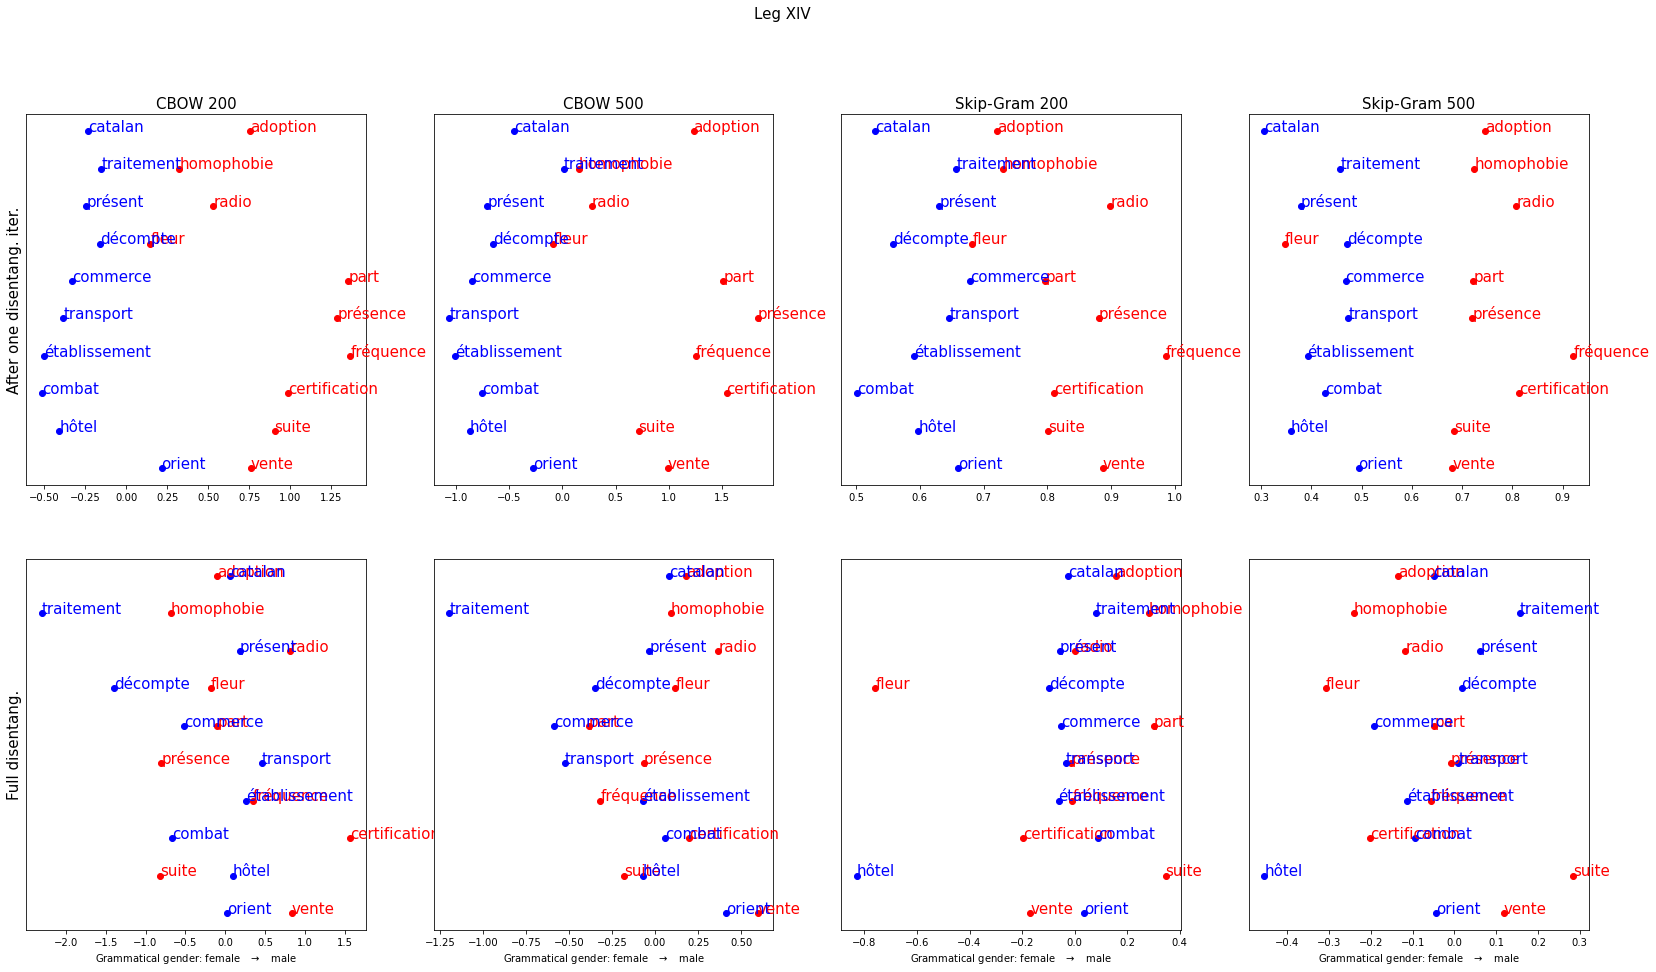

In [48]:
fig, axes = plt.subplots(2, 4, figsize=(28, 15))
font_size=15

# plot projection 
scatter_align_words(proj_1_fem_cbow_XIV_200.reshape(-1), proj_1_masc_cbow_XIV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 0], plot_vertical_0=False)
scatter_align_words(proj_1_fem_cbow_XIV_500.reshape(-1), proj_1_masc_cbow_XIV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 1], plot_vertical_0=False)
scatter_align_words(proj_1_fem_sg_XIV_200.reshape(-1), proj_1_masc_sg_XIV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 2], plot_vertical_0=False)
scatter_align_words(proj_1_fem_sg_XIV_500.reshape(-1), proj_1_masc_sg_XIV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 3], plot_vertical_0=False)

scatter_align_words(proj_full_fem_cbow_XIV_200.reshape(-1), proj_full_masc_cbow_XIV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 0], plot_vertical_0=False)
scatter_align_words(proj_full_fem_cbow_XIV_500.reshape(-1), proj_full_masc_cbow_XIV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 1], plot_vertical_0=False)
scatter_align_words(proj_full_fem_sg_XIV_200.reshape(-1), proj_full_masc_sg_XIV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 2], plot_vertical_0=False)
scatter_align_words(proj_full_fem_sg_XIV_500.reshape(-1), proj_full_masc_sg_XIV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 3], plot_vertical_0=False)

# labeling plots and axes
axes[0, 0].set_ylabel("After one disentang. iter.", fontsize=font_size)
axes[1, 0].set_ylabel("Full disentang.", fontsize=font_size)

axes[0, 0].set_title("CBOW 200", fontsize=font_size)
axes[0, 1].set_title("CBOW 500", fontsize=font_size)
axes[0, 2].set_title("Skip-Gram 200", fontsize=font_size)
axes[0, 3].set_title("Skip-Gram 500", fontsize=font_size)

axes[1, 0].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 2].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 3].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)

# remove yticks 
axes[0, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 2].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 3].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 2].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 3].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)

plt.suptitle('Leg XIV',fontsize=font_size)

plt.show()


In [38]:
n_words = 10

# one disentanglement iteration
disen_1_fem_cbow_XV_200, disen_1_masc_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, final_gram_fem[:n_words], gram_dir_cbow_XV_200[0:1]), disentangle_gram_dirct(cbow_XV_200, final_gram_masc[:n_words], gram_dir_cbow_XV_200[0:1])
disen_1_fem_cbow_XV_500, disen_1_masc_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, final_gram_fem[:n_words], gram_dir_cbow_XV_500[0:1]), disentangle_gram_dirct(cbow_XV_500, final_gram_masc[:n_words], gram_dir_cbow_XV_500[0:1])
disen_1_fem_sg_XV_200, disen_1_masc_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, final_gram_fem[:n_words], gram_dir_sg_XV_200[0:1]), disentangle_gram_dirct(sg_XV_200, final_gram_masc[:n_words], gram_dir_sg_XV_200[0:1])
disen_1_fem_sg_XV_500, disen_1_masc_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, final_gram_fem[:n_words], gram_dir_sg_XV_500[0:1]), disentangle_gram_dirct(sg_XV_500, final_gram_masc[:n_words], gram_dir_sg_XV_500[0:1])

proj_1_fem_cbow_XV_200, proj_1_masc_cbow_XV_200 = proj_onto_space(disen_1_fem_cbow_XV_200, gram_dir_cbow_XV_200[1]), proj_onto_space(disen_1_masc_cbow_XV_200, gram_dir_cbow_XV_200[1])
proj_1_fem_cbow_XV_500, proj_1_masc_cbow_XV_500 = proj_onto_space(disen_1_fem_cbow_XV_500, gram_dir_cbow_XV_500[1]), proj_onto_space(disen_1_masc_cbow_XV_500, gram_dir_cbow_XV_500[1])
proj_1_fem_sg_XV_200, proj_1_masc_sg_XV_200 = proj_onto_space(disen_1_fem_sg_XV_200, gram_dir_sg_XV_200[1]), proj_onto_space(disen_1_masc_sg_XV_200, gram_dir_sg_XV_200[1])
proj_1_fem_sg_XV_500, proj_1_masc_sg_XV_500 = proj_onto_space(disen_1_fem_sg_XV_500, gram_dir_sg_XV_500[1]), proj_onto_space(disen_1_masc_sg_XV_500, gram_dir_sg_XV_500[1])

# full disentanglement iteration
disen_full_fem_cbow_XV_200, disen_full_masc_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, final_gram_fem[:n_words], gram_dir_cbow_XV_200[:-1]), disentangle_gram_dirct(cbow_XV_200, final_gram_masc[:n_words], gram_dir_cbow_XV_200[:-1])
disen_full_fem_cbow_XV_500, disen_full_masc_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, final_gram_fem[:n_words], gram_dir_cbow_XV_500[:-1]), disentangle_gram_dirct(cbow_XV_500, final_gram_masc[:n_words], gram_dir_cbow_XV_500[:-1])
disen_full_fem_sg_XV_200, disen_full_masc_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, final_gram_fem[:n_words], gram_dir_sg_XV_200[:-1]), disentangle_gram_dirct(sg_XV_200, final_gram_masc[:n_words], gram_dir_sg_XV_200[:-1])
disen_full_fem_sg_XV_500, disen_full_masc_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, final_gram_fem[:n_words], gram_dir_sg_XV_500[:-1]), disentangle_gram_dirct(sg_XV_500, final_gram_masc[:n_words], gram_dir_sg_XV_500[:-1])

proj_full_fem_cbow_XV_200, proj_full_masc_cbow_XV_200 = proj_onto_space(disen_full_fem_cbow_XV_200, gram_dir_cbow_XV_200[-1]), proj_onto_space(disen_full_masc_cbow_XV_200, gram_dir_cbow_XV_200[-1])
proj_full_fem_cbow_XV_500, proj_full_masc_cbow_XV_500 = proj_onto_space(disen_full_fem_cbow_XV_500, gram_dir_cbow_XV_500[-1]), proj_onto_space(disen_full_masc_cbow_XV_500, gram_dir_cbow_XV_500[-1])
proj_full_fem_sg_XV_200, proj_full_masc_sg_XV_200 = proj_onto_space(disen_full_fem_sg_XV_200, gram_dir_sg_XV_200[-1]), proj_onto_space(disen_full_masc_sg_XV_200, gram_dir_sg_XV_200[-1])
proj_full_fem_sg_XV_500, proj_full_masc_sg_XV_500 = proj_onto_space(disen_full_fem_sg_XV_500, gram_dir_sg_XV_500[-1]), proj_onto_space(disen_full_masc_sg_XV_500, gram_dir_sg_XV_500[-1])

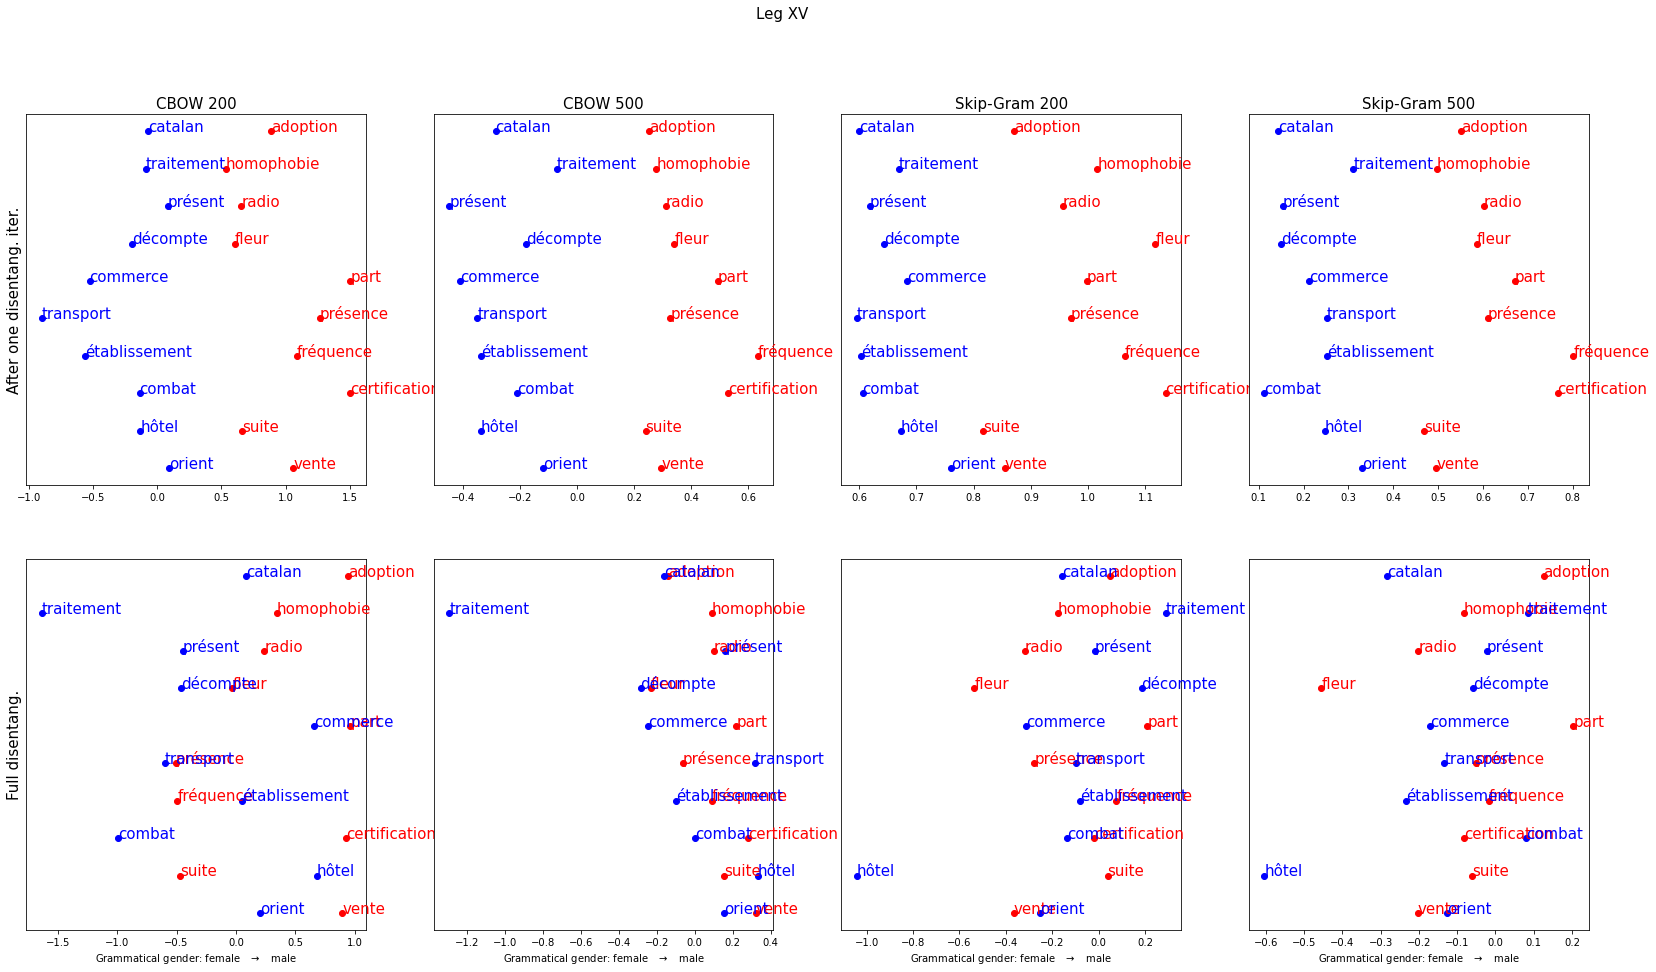

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(28, 15))
font_size=15

#gram_list_test = list(zip(gram_list_fem, gram_list_masc))

# plot projection 
scatter_align_words(proj_1_fem_cbow_XV_200.reshape(-1), proj_1_masc_cbow_XV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 0], plot_vertical_0=False)
scatter_align_words(proj_1_fem_cbow_XV_500.reshape(-1), proj_1_masc_cbow_XV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 1], plot_vertical_0=False)
scatter_align_words(proj_1_fem_sg_XV_200.reshape(-1), proj_1_masc_sg_XV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 2], plot_vertical_0=False)
scatter_align_words(proj_1_fem_sg_XV_500.reshape(-1), proj_1_masc_sg_XV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[0, 3], plot_vertical_0=False)

scatter_align_words(proj_full_fem_cbow_XV_200.reshape(-1), proj_full_masc_cbow_XV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 0], plot_vertical_0=False)
scatter_align_words(proj_full_fem_cbow_XV_500.reshape(-1), proj_full_masc_cbow_XV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 1], plot_vertical_0=False)
scatter_align_words(proj_full_fem_sg_XV_200.reshape(-1), proj_full_masc_sg_XV_200.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 2], plot_vertical_0=False)
scatter_align_words(proj_full_fem_sg_XV_500.reshape(-1), proj_full_masc_sg_XV_500.reshape(-1), final_gram_fem[:n_words], final_gram_masc[:n_words], ax=axes[1, 3], plot_vertical_0=False)


# labeling plots and axes
axes[0, 0].set_ylabel("After one disentang. iter.", fontsize=font_size)
axes[1, 0].set_ylabel("Full disentang.", fontsize=font_size)

axes[0, 0].set_title("CBOW 200", fontsize=font_size)
axes[0, 1].set_title("CBOW 500", fontsize=font_size)
axes[0, 2].set_title("Skip-Gram 200", fontsize=font_size)
axes[0, 3].set_title("Skip-Gram 500", fontsize=font_size)

axes[1, 0].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 2].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 3].set_xlabel(r"Grammatical gender: female   $\rightarrow$   male", fontsize=10)


# remove yticks 
axes[0, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 2].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[0, 3].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 2].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)
axes[1, 3].tick_params(left = False, right = False , labelleft = False , labelbottom = True, bottom = True)



plt.suptitle('Leg XV',fontsize=font_size)

plt.show()


**Comment:**

We see how inefficient one grammatical disentanglement step is compared to full disentanglement. In fact, words are still grammatically separable even after the first disentanglement step.

### <a id="semantic-lda-after-disen">2.3. Detection of semantic gender direction using LDA after disentanglement</a> ([&uarr;](#content))

Now, we will use LDA to identify the semantic gender direction after removing the grammatical gender component out of the gender-defintion words.


*List of gender-definition words*

In [20]:
#gender_list = [["femme", "homme"], ["femmes", "hommes"], ['mme', 'mr'], ['fille', 'fils'], ["mère", "père"], ["mères", "pères"], ['sœur', 'frère'], ['madame', 'monsieur']]
#gender_list = [['fille', 'garçon'], ["mère", "père"], ["mères", "pères"], ['épouse', 'époux'], ['conjointe', 'conjoint'], ['citoyenne', 'citoyen']]
#female_related_words = 'femme fille femmes filles mère mères conjointe épouse enceinte enceintes dame madame accouchement sein gynécologie féminin reine mariée mme'.split()
#male_related_words = 'homme garçon fils hommes garçons père pères conjoint époux monsieur roi marié mr masculin testicules sperme prostate'.split()
female_related_words = "fille mère épouse soeur féminin".split()
male_related_words = "garçon père époux frère masculin".split()


female_related_words = "fille mère mères épouse femmes femme citoyenne conjointe".split()
male_related_words = "garçon père pères époux hommes homme citoyen conjoint".split()

female_related_words = "fille mère soeur madame femme mme féminin".split()
male_related_words = "garçon père frère monsieur homme mr masculin".split()



#female_occup = "employée directrice enseignante infirmière avocate ouvrière présidente députée".split()
#male_occup = "employé directeur enseignant infirmier avocat ouvrier président député".split()

#female_related_words.extend(female_occup)
#male_related_words.extend(male_occup)

*Grammatically disentangle gender-definition words*

In [21]:
# disentangle gender-definition words 
disen_female_cbow_XIV_200, disen_male_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, female_related_words, gram_dir_cbow_XIV_200), disentangle_gram_dirct(cbow_XIV_200, male_related_words, gram_dir_cbow_XIV_200)
disen_female_cbow_XIV_500, disen_male_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, female_related_words, gram_dir_cbow_XIV_500), disentangle_gram_dirct(cbow_XIV_500, male_related_words, gram_dir_cbow_XIV_500)
disen_female_sg_XIV_200, disen_male_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, female_related_words, gram_dir_sg_XIV_200), disentangle_gram_dirct(sg_XIV_200, male_related_words, gram_dir_sg_XIV_200)
disen_female_sg_XIV_500, disen_male_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, female_related_words, gram_dir_sg_XIV_500), disentangle_gram_dirct(sg_XIV_500, male_related_words, gram_dir_sg_XIV_500)

disen_female_cbow_XV_200, disen_male_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, female_related_words, gram_dir_cbow_XV_200), disentangle_gram_dirct(cbow_XV_200, male_related_words, gram_dir_cbow_XV_200)
disen_female_cbow_XV_500, disen_male_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, female_related_words, gram_dir_cbow_XV_500), disentangle_gram_dirct(cbow_XV_500, male_related_words, gram_dir_cbow_XV_500)
disen_female_sg_XV_200, disen_male_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, female_related_words, gram_dir_sg_XV_200), disentangle_gram_dirct(sg_XV_200, male_related_words, gram_dir_sg_XV_200)
disen_female_sg_XV_500, disen_male_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, female_related_words, gram_dir_sg_XV_500), disentangle_gram_dirct(sg_XV_500, male_related_words, gram_dir_sg_XV_500)

In [22]:
# using LDA to exhibit the semantic gender direction
def semantic_dirct_LDA(fem_emb, male_emb):
    assert len(fem_emb) == len(male_emb), "list_words1 and list_words2 should be of same size !"
    X = np.concatenate((fem_emb, male_emb), axis=0)
    y = np.concatenate((np.zeros(len(fem_emb)), np.ones(len(male_emb))), axis=0)
    # shuffle data for security
    np.random.seed(42)
    idx = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
    X = X[idx] 
    y = y[idx]

    lda = LDA()
    lda.fit(X, y)
    score = lda.score(X, y)
    # principal direction of change
    dirct = -(lda.scalings_/(np.linalg.norm(lda.scalings_, ord=2))).reshape(-1,1)
    return score, dirct


*Exhibit the semantic gender direction using LDA*

In [23]:
scores_sem_cbow_XIV_200, sem_dir_cbow_XIV_200 = semantic_dirct_LDA(disen_female_cbow_XIV_200, disen_male_cbow_XIV_200)
scores_sem_cbow_XIV_500, sem_dir_cbow_XIV_500 = semantic_dirct_LDA(disen_female_cbow_XIV_500, disen_male_cbow_XIV_500)
scores_sem_sg_XIV_200, sem_dir_sg_XIV_200 = semantic_dirct_LDA(disen_female_sg_XIV_200, disen_male_sg_XIV_200)
scores_sem_sg_XIV_500, sem_dir_sg_XIV_500 = semantic_dirct_LDA(disen_female_sg_XIV_500, disen_male_sg_XIV_500)

scores_sem_cbow_XV_200, sem_dir_cbow_XV_200 = semantic_dirct_LDA(disen_female_cbow_XV_200, disen_male_cbow_XV_200)
scores_sem_cbow_XV_500, sem_dir_cbow_XV_500 = semantic_dirct_LDA(disen_female_cbow_XV_500, disen_male_cbow_XV_500)
scores_sem_sg_XV_200, sem_dir_sg_XV_200 = semantic_dirct_LDA(disen_female_sg_XV_200, disen_male_sg_XV_200)
scores_sem_sg_XV_500, sem_dir_sg_XV_500 = semantic_dirct_LDA(disen_female_sg_XV_500, disen_male_sg_XV_500)

print(scores_sem_cbow_XIV_200, scores_sem_cbow_XIV_500, scores_sem_sg_XIV_200, scores_sem_sg_XIV_500)
print(scores_sem_cbow_XV_200, scores_sem_cbow_XV_500, scores_sem_sg_XV_200, scores_sem_sg_XV_500)

0.8571428571428571 0.7857142857142857 0.7142857142857143 0.7142857142857143
0.8571428571428571 0.7857142857142857 0.5714285714285714 0.7142857142857143


**Comment:** The semantic classification training scores are quite good, especially for CBOW models. We will make plots of the words on the identified semantic gender direction to confirm this.

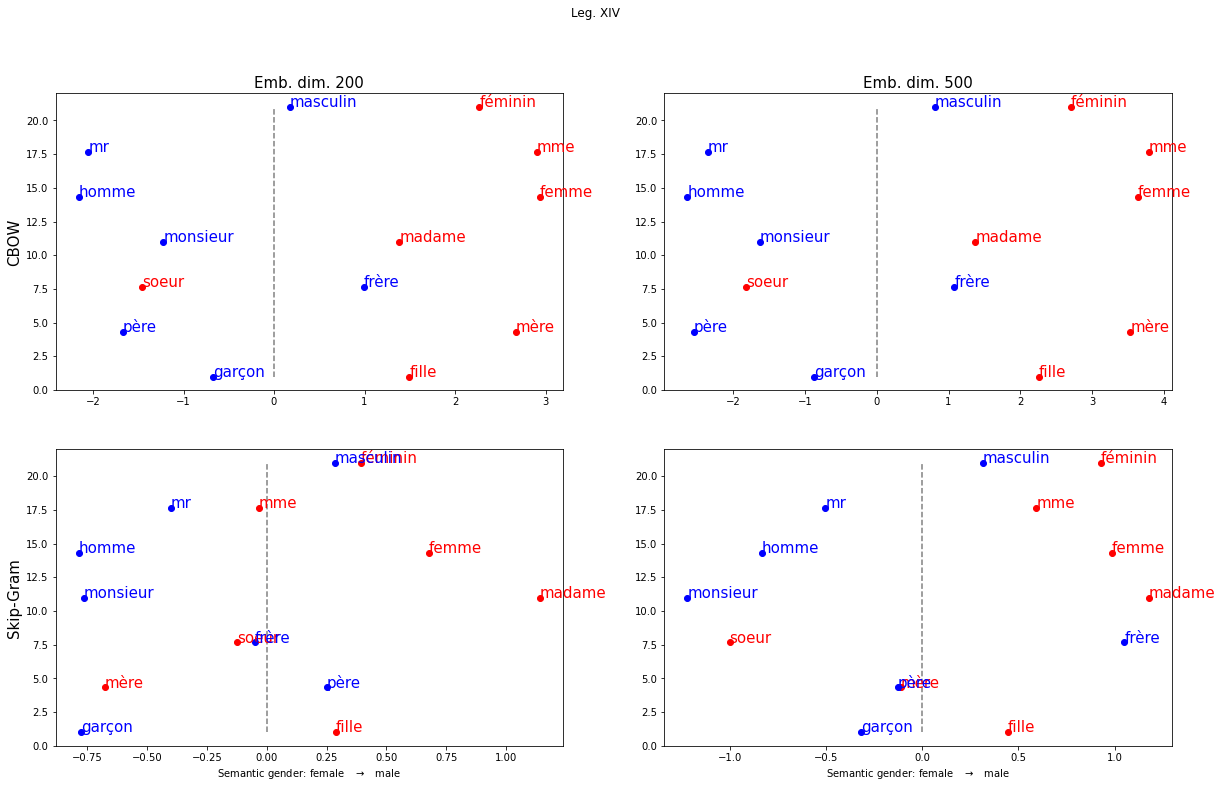

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
font_size=15

# projection of gender definition words onto the gender space (1st principal component)
female_proj_cbow_XIV_200, male_proj_cbow_XIV_200 = proj_onto_space(disen_female_cbow_XIV_200, sem_dir_cbow_XIV_200), proj_onto_space(disen_male_cbow_XIV_200, sem_dir_cbow_XIV_200)
female_proj_cbow_XIV_500, male_proj_cbow_XIV_500 = proj_onto_space(disen_female_cbow_XIV_500, sem_dir_cbow_XIV_500), proj_onto_space(disen_male_cbow_XIV_500, sem_dir_cbow_XIV_500)
female_proj_sg_XIV_200, male_proj_sg_XIV_200 = proj_onto_space(disen_female_sg_XIV_200, sem_dir_sg_XIV_200), proj_onto_space(disen_male_sg_XIV_200, sem_dir_sg_XIV_200)
female_proj_sg_XIV_500, male_proj_sg_XIV_500 = proj_onto_space(disen_female_sg_XIV_500, sem_dir_sg_XIV_500), proj_onto_space(disen_male_sg_XIV_500, sem_dir_sg_XIV_500)

# plot projection 
scatter_align_words(female_proj_cbow_XIV_200.reshape(-1), male_proj_cbow_XIV_200.reshape(-1), female_related_words, male_related_words, ax=axes[0, 0], plot_vertical_0=True)
scatter_align_words(female_proj_cbow_XIV_500.reshape(-1), male_proj_cbow_XIV_500.reshape(-1), female_related_words, male_related_words, ax=axes[0, 1], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XIV_200.reshape(-1), male_proj_sg_XIV_200.reshape(-1),female_related_words, male_related_words, ax=axes[1, 0], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XIV_500.reshape(-1), male_proj_sg_XIV_500.reshape(-1), female_related_words, male_related_words, ax=axes[1, 1], plot_vertical_0=True)

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.suptitle('Leg. XIV')

plt.show()

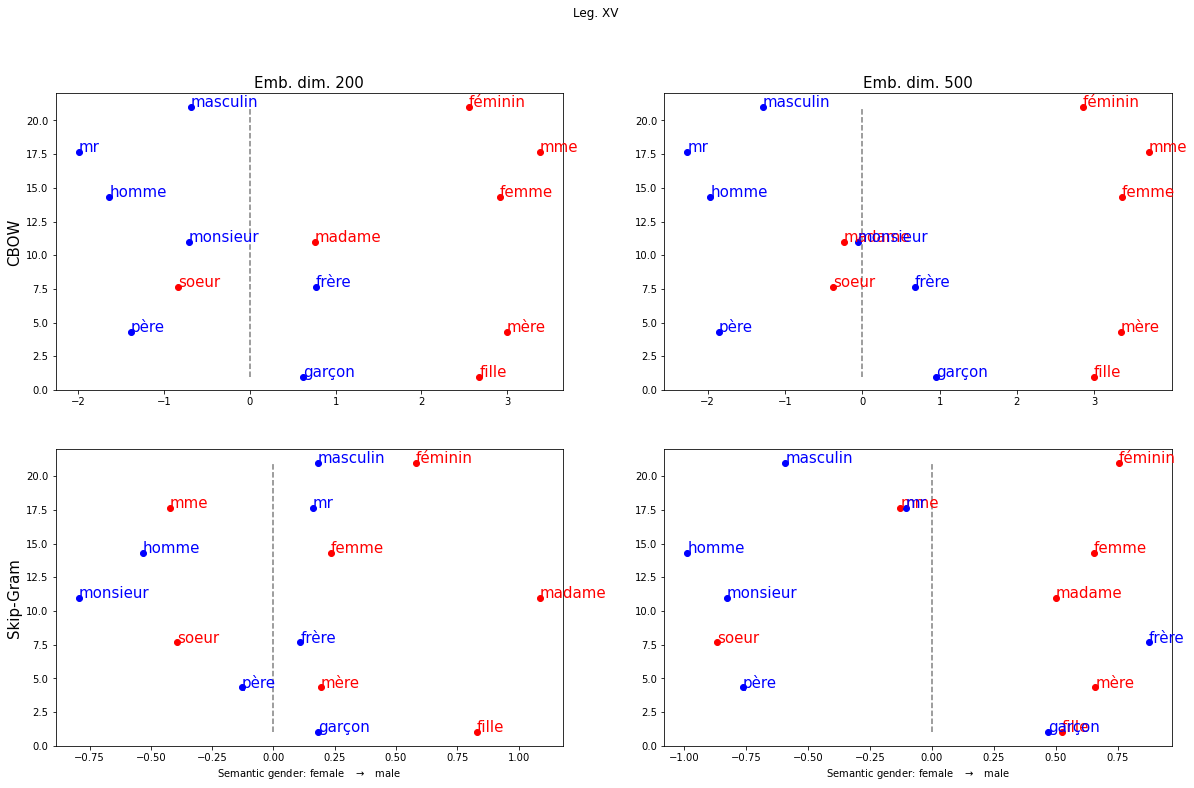

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
font_size=15

# projection of gender definition words onto the gender space (1st principal component)
female_proj_cbow_XV_200, male_proj_cbow_XV_200 = proj_onto_space(disen_female_cbow_XV_200, sem_dir_cbow_XV_200), proj_onto_space(disen_male_cbow_XV_200, sem_dir_cbow_XV_200)
female_proj_cbow_XV_500, male_proj_cbow_XV_500 = proj_onto_space(disen_female_cbow_XV_500, sem_dir_cbow_XV_500), proj_onto_space(disen_male_cbow_XV_500, sem_dir_cbow_XV_500)
female_proj_sg_XV_200, male_proj_sg_XV_200 = proj_onto_space(disen_female_sg_XV_200, sem_dir_sg_XV_200), proj_onto_space(disen_male_sg_XV_200, sem_dir_sg_XV_200)
female_proj_sg_XV_500, male_proj_sg_XV_500 = proj_onto_space(disen_female_sg_XV_500, sem_dir_sg_XV_500), proj_onto_space(disen_male_sg_XV_500, sem_dir_sg_XV_500)

# plot projection 
scatter_align_words(female_proj_cbow_XV_200.reshape(-1), male_proj_cbow_XV_200.reshape(-1), female_related_words, male_related_words, ax=axes[0, 0], plot_vertical_0=True)
scatter_align_words(female_proj_cbow_XV_500.reshape(-1), male_proj_cbow_XV_500.reshape(-1), female_related_words, male_related_words, ax=axes[0, 1], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XV_200.reshape(-1), male_proj_sg_XV_200.reshape(-1),female_related_words, male_related_words, ax=axes[1, 0], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XV_500.reshape(-1), male_proj_sg_XV_500.reshape(-1), female_related_words, male_related_words, ax=axes[1, 1], plot_vertical_0=True)

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.suptitle('Leg. XV')

plt.show()

**Comment:** Most of the word in the gender pairs are well-separated. We can see that this method works quite well for CBOW as opposed to Skip-Gram. In a sense, this could mean that CBOW models have a better capability to capture gender semantics than Skip-Gram, which may partly be explained by the fact that the idea behind CBOW (i.e. predicting the target word given the context) is more rational than that of Skip-Gram (predicting the context given the target word).

### <a id="semantic-pca-after-disen">2.4. Detection of semantic gender direction using PCA after disentanglement</a> ([&uarr;](#content))

*Detecting semantic gender direction by applying PCA to the differences between words in gender pairs*

In [161]:
# using LDA to exhibit the semantic gender direction
def semantic_dirct_PCA(fem_emb, male_emb, get_sing_values=True):
    assert len(fem_emb) == len(male_emb), "list_words1 and list_words2 should be of same size !"
    X = fem_emb - male_emb
    pca = PCA(n_components=len(fem_emb), random_state=42)
    pca.fit(X)
    if get_sing_values:
        return pca.singular_values_, pca.components_ 
    else:
        return pca.components

In [162]:
sing_val_sem_cbow_XIV_200, sem_dir_cbow_XIV_200 = semantic_dirct_PCA(disen_female_cbow_XIV_200, disen_male_cbow_XIV_200)
sing_val_sem_cbow_XIV_500, sem_dir_cbow_XIV_500 = semantic_dirct_PCA(disen_female_cbow_XIV_500, disen_male_cbow_XIV_500)
sing_val_sem_sg_XIV_200, sem_dir_sg_XIV_200 = semantic_dirct_PCA(disen_female_sg_XIV_200, disen_male_sg_XIV_200)
sing_val_sem_sg_XIV_500, sem_dir_sg_XIV_500 = semantic_dirct_PCA(disen_female_sg_XIV_500, disen_male_sg_XIV_500)

sing_val_sem_cbow_XV_200, sem_dir_cbow_XV_200 = semantic_dirct_PCA(disen_female_cbow_XV_200, disen_male_cbow_XV_200)
sing_val_sem_cbow_XV_500, sem_dir_cbow_XV_500 = semantic_dirct_PCA(disen_female_cbow_XV_500, disen_male_cbow_XV_500)
sing_val_sem_sg_XV_200, sem_dir_sg_XV_200 = semantic_dirct_PCA(disen_female_sg_XV_200, disen_male_sg_XV_200)
sing_val_sem_sg_XV_500, sem_dir_sg_XV_500 = semantic_dirct_PCA(disen_female_sg_XV_500, disen_male_sg_XV_500)


*Plot of PCA singular values*

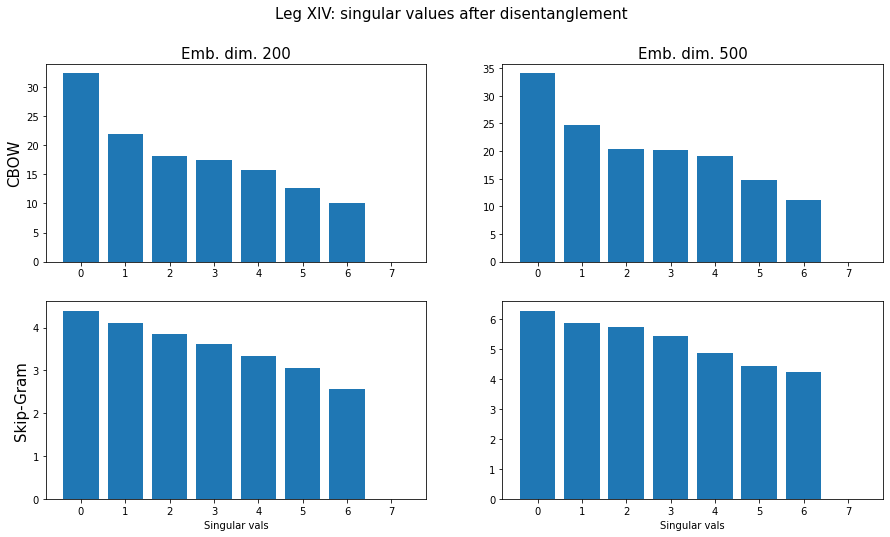

In [163]:
# plot the gender-space singular values of each word2vec model
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
font_size=15

axes[0, 0].bar(x=np.arange(len(sing_val_sem_cbow_XIV_200)), height=sing_val_sem_cbow_XIV_200)
axes[0, 1].bar(x=np.arange(len(sing_val_sem_cbow_XIV_500)), height=sing_val_sem_cbow_XIV_500)
axes[1, 0].bar(x=np.arange(len(sing_val_sem_sg_XIV_200)), height=sing_val_sem_sg_XIV_200)
axes[1, 1].bar(x=np.arange(len(sing_val_sem_sg_XIV_500)), height=sing_val_sem_sg_XIV_500)

# axis labeling
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel("Singular vals",)
axes[1, 1].set_xlabel("Singular vals",)

# set plot titles
axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
plt.suptitle('Leg XIV: singular values after disentanglement',fontsize=font_size)

plt.show()

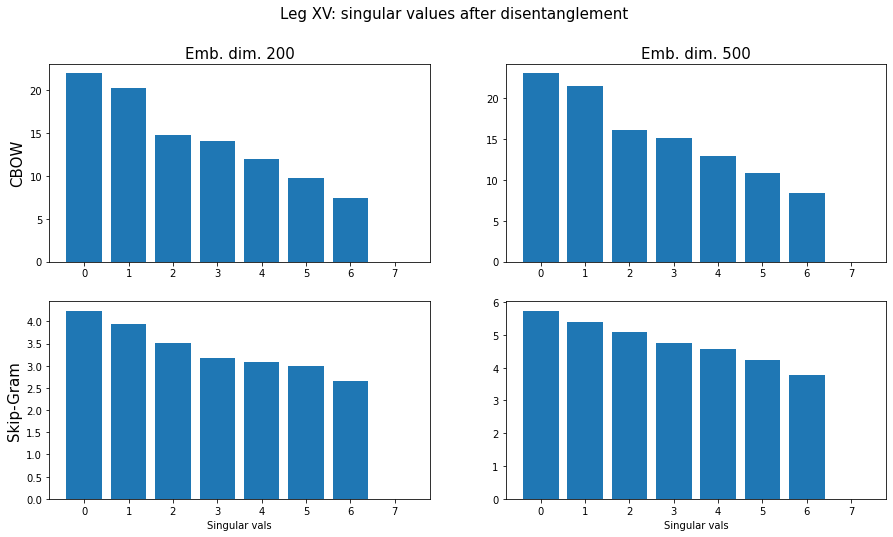

In [164]:
# plot the gender-space singular values of each word2vec model
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
font_size=15

axes[0, 0].bar(x=np.arange(len(sing_val_sem_cbow_XV_200)), height=sing_val_sem_cbow_XV_200)
axes[0, 1].bar(x=np.arange(len(sing_val_sem_cbow_XV_500)), height=sing_val_sem_cbow_XV_500)
axes[1, 0].bar(x=np.arange(len(sing_val_sem_sg_XV_200)), height=sing_val_sem_sg_XV_200)
axes[1, 1].bar(x=np.arange(len(sing_val_sem_sg_XV_500)), height=sing_val_sem_sg_XV_500)

# axis labeling
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel("Singular vals",)
axes[1, 1].set_xlabel("Singular vals",)

# set plot titles
axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
plt.suptitle('Leg XV: singular values after disentanglement',fontsize=font_size)

plt.show()

**Comment:** There is no huge gap between the 1st singular value and the others.

*Projection on the semantic gender direction*

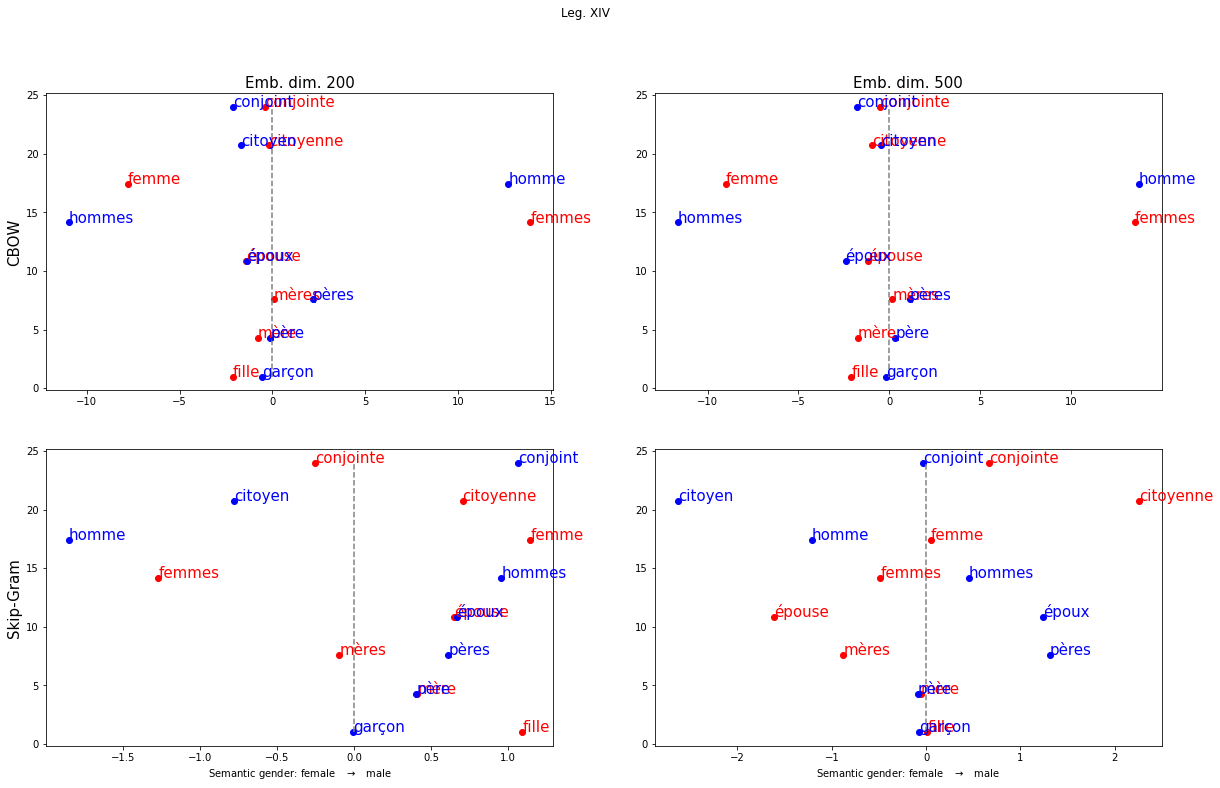

In [165]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
font_size=15

# projection of gender definition words onto the gender space (1st principal component)
female_proj_cbow_XIV_200, male_proj_cbow_XIV_200 = proj_onto_space(disen_female_cbow_XIV_200, sem_dir_cbow_XIV_200[0]), proj_onto_space(disen_male_cbow_XIV_200, sem_dir_cbow_XIV_200[0])
female_proj_cbow_XIV_500, male_proj_cbow_XIV_500 = proj_onto_space(disen_female_cbow_XIV_500, sem_dir_cbow_XIV_500[0]), proj_onto_space(disen_male_cbow_XIV_500, sem_dir_cbow_XIV_500[0])
female_proj_sg_XIV_200, male_proj_sg_XIV_200 = proj_onto_space(disen_female_sg_XIV_200, sem_dir_sg_XIV_200[0]), proj_onto_space(disen_male_sg_XIV_200, sem_dir_sg_XIV_200[0])
female_proj_sg_XIV_500, male_proj_sg_XIV_500 = proj_onto_space(disen_female_sg_XIV_500, sem_dir_sg_XIV_500[0]), proj_onto_space(disen_male_sg_XIV_500, sem_dir_sg_XIV_500[0])

# plot projection 
scatter_align_words(female_proj_cbow_XIV_200.reshape(-1), male_proj_cbow_XIV_200.reshape(-1), female_related_words, male_related_words, ax=axes[0, 0], plot_vertical_0=True)
scatter_align_words(female_proj_cbow_XIV_500.reshape(-1), male_proj_cbow_XIV_500.reshape(-1), female_related_words, male_related_words, ax=axes[0, 1], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XIV_200.reshape(-1), male_proj_sg_XIV_200.reshape(-1),female_related_words, male_related_words, ax=axes[1, 0], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XIV_500.reshape(-1), male_proj_sg_XIV_500.reshape(-1), female_related_words, male_related_words, ax=axes[1, 1], plot_vertical_0=True)

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.suptitle('Leg. XIV')

plt.show()

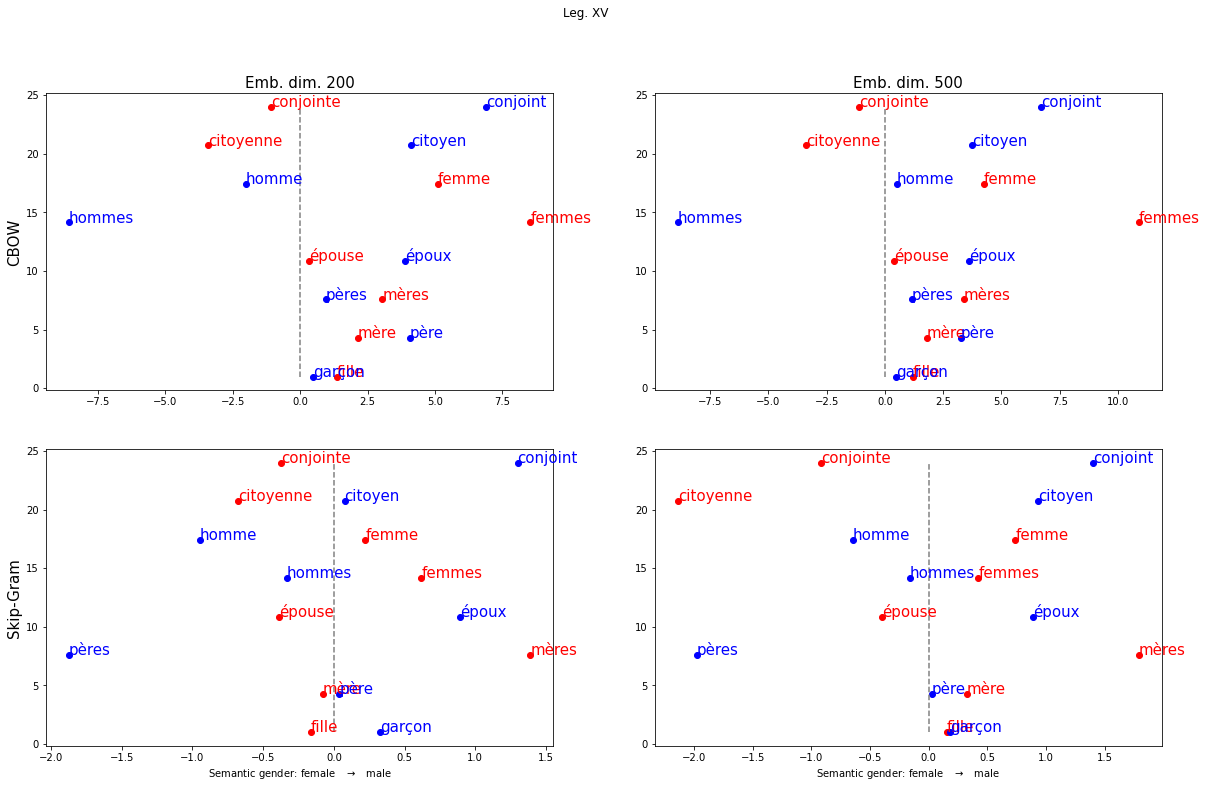

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
font_size=15

# projection of gender definition words onto the gender space (1st principal component)
female_proj_cbow_XV_200, male_proj_cbow_XV_200 = proj_onto_space(disen_female_cbow_XV_200, sem_dir_cbow_XV_200[0]), proj_onto_space(disen_male_cbow_XV_200, sem_dir_cbow_XV_200[0])
female_proj_cbow_XV_500, male_proj_cbow_XV_500 = proj_onto_space(disen_female_cbow_XV_500, sem_dir_cbow_XV_500[0]), proj_onto_space(disen_male_cbow_XV_500, sem_dir_cbow_XV_500[0])
female_proj_sg_XV_200, male_proj_sg_XV_200 = proj_onto_space(disen_female_sg_XV_200, sem_dir_sg_XV_200[0]), proj_onto_space(disen_male_sg_XV_200, sem_dir_sg_XV_200[0])
female_proj_sg_XV_500, male_proj_sg_XV_500 = proj_onto_space(disen_female_sg_XV_500, sem_dir_sg_XV_500[0]), proj_onto_space(disen_male_sg_XV_500, sem_dir_sg_XV_500[0])

# plot projection 
scatter_align_words(female_proj_cbow_XV_200.reshape(-1), male_proj_cbow_XV_200.reshape(-1), female_related_words, male_related_words, ax=axes[0, 0], plot_vertical_0=True)
scatter_align_words(female_proj_cbow_XV_500.reshape(-1), male_proj_cbow_XV_500.reshape(-1), female_related_words, male_related_words, ax=axes[0, 1], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XV_200.reshape(-1), male_proj_sg_XV_200.reshape(-1),female_related_words, male_related_words, ax=axes[1, 0], plot_vertical_0=True)
scatter_align_words(female_proj_sg_XV_500.reshape(-1), male_proj_sg_XV_500.reshape(-1), female_related_words, male_related_words, ax=axes[1, 1], plot_vertical_0=True)

# labeling plots and axes
axes[0, 0].set_ylabel("CBOW", fontsize=font_size)
axes[1, 0].set_ylabel("Skip-Gram", fontsize=font_size)

axes[0, 0].set_title("Emb. dim. 200", fontsize=font_size)
axes[0, 1].set_title("Emb. dim. 500", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.suptitle('Leg. XV')

plt.show()

### <a id="conclusion">3. Conclusion</a> ([&uarr;](#content))

* The grammatical gender direction detection through an iterative process is more efficient than one step disentanglement. The successively-identified grammatical gender directions are used to grammatically disentangle word embeddings later. 

* The semantic gender direction detection did not work well with different methods. Slighly better results were witnessed with LDA. The specificity of the corpora that makes harder to expect the use of gender words in the same contexts that exhibit gender semantics as in the plain language might be a possible explanation. 
  

* In the context of this project, we will only need the identification of the grammatical gender direction in order to disentangle the grammatical gender component from the word embeddings. 

* The semantic gender direction will not be useful since it does not intervene in the computation of the WEAT bias metrics (recall we only need the target word sets X, Y and the attribute sets A, B). However, the unsuccessful results of detecting the semantic gender direction are to be kept in mind during the interpretation of the gender bias measurement results.

### <a id="references">4. References</a> ([&uarr;](#content))


[[1](https://aclanthology.org/D19-1531.pdf)] P. Zhou et al., *[Examining Gender Bias in Languages with Grammatical Gender](https://aclanthology.org/D19-1531.pdf)*, Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing, 2019.

[[2](https://arxiv.org/pdf/2206.01691.pdf)] S. O. Sabbaghi, A. Caliskan, *[Measuring Gender Bias in Word Embeddings of Gendered
Languages Requires Disentangling Grammatical Gender Signals](https://arxiv.org/pdf/2206.01691.pdf)*, Proceedings of the 2022 AAAI/ACM Conference on AI, Ethics, and Society, 2022.